## 3.8 Can a network learn $\beta_i^{RD}$ for variable input $x$?


First we have to determine what a good cost function to test all this on is. We can simulate some networks over weights and over a distribution of inputs $x$. From this we can produce a cost function landscape, finding the right parameterizations to then rerun the simulation with the learning rule on top. The learning rule requires the cost function, so these simulations must already have its parameters determined, we can't run simulations and then determine the right parameters in the analysis post facto.

In [35]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import numpy as np
import numpy.random as rand
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from lib.lif import LIF, ParamsLIF, LSM, ParamsLSM, LSM_const

n = 2               # Number of neurons
tau_s = 0.020       # Time scale for output filter
mu = 1              # Threshold
t = 1               # Time for each epoch
nsims = 1000        # Number of epochs
N = 30              # Number of W values we sweep over
wmax = 1            # Max W value of sweep
wmin = 16           # Min w value of sweep
eta = 1             # Learning rate
sigma = 1           # Spread of input x distribution
x_mu = 3            # Baseline input level
c = 0.75            # Noise correlation coefficient

alpha1 = 1000
alpha2 = -1000

#Load the precomputed sims from
fn_in = './sweeps/learningcostfunc_variablex_sweepw.npz'
a = np.load(fn_in)

Populating the interactive namespace from numpy and matplotlib


In [36]:
wvals = a['wvals']
xs = a['xs']
ss = a['ss']

In [37]:
cost = np.zeros(xs.shape[0:2])

In [38]:
for i in range(len(wvals)):
    for j in range(len(wvals)):
        c = 0
        for k in range(nsims):
            x = xs[i,j,k]
            s1 = ss[i,j,k,0,:]
            s2 = ss[i,j,k,1,:]
            ct = np.mean((alpha1*s1+alpha2*s2-(x)**2).astype(np.float32)**2)/nsims
            c += ct
        cost[i,j] = c

In [39]:
wmin = 1; wmax = 16; N = 30

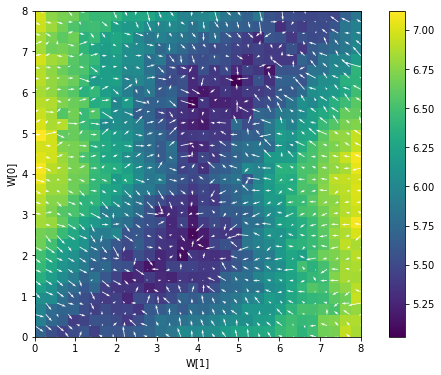

In [42]:
fig,ax = plt.subplots(1,1)
a=ax.imshow(np.log(cost), origin='lower', extent=[wmin, wmax, wmin, wmax])
plt.colorbar(a)
ax.set_ylabel('W[0]')
ax.set_xlabel('W[1]')
grad = np.gradient(np.log(cost))
X, Y = np.meshgrid(np.linspace(wmin,wmax,N), np.linspace(wmin,wmax,N))
ax.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))

This looks pretty good actually. Things get noisier over a range of $x$ values.

## Learning $\beta^{RD}$ with variable $x$, for one set of weights

In [7]:
#Simulate 1000 times, for a fixed W1 and W2.
n = 2               # Number of neurons
q = 100             # Number of LSM neurons
x = 2               # Constant input
alpha1 = -100       # Cost function params
alpha2 = -1500      # Cost function params
tau_s = 0.060       # Time scale for output filter
mu = 1              # Threshold
p = 0.05            # Window size
t = 1               # Time for each epoch
N = 2000            # Number of epochs
eta = .5            # Learning rate
sigma = 1           # Spread of input x distribution
x_mu = 3

w0 = 5
w1 = 5

# Filename for results
#fn_out = './sweeps/learningbeta_fixedx_sweepw.npz'

params = ParamsLSM(q = q, p = 1, t = t)
lsm = LSM(params)
params_lif = ParamsLIF(c = 0.75)
lif = LIF(params_lif, t = t)

t_filter = np.linspace(0, 0.45, 450)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

beta_rd = np.zeros((n, N))
beta_bp = np.zeros((n, N))
xs = np.zeros((N))

#init weights
lif.W = np.array([w0, w1])
V = np.ones((n,q))

for idx in range(N):
    #Choose x at random
    x = sigma*rand.randn() + x_mu
    #x = 2
    xs[idx] = x
    #Simulate LSM
    s_lsm = lsm.simulate(x)
    #Simulate LIF
    lif.x = x
    (v, h, _, _) = lif.simulate()
    s1 = np.convolve(h[0,:], exp_filter)[0:h.shape[1]]
    s2 = np.convolve(h[1,:], exp_filter)[0:h.shape[1]]            
    cost = (alpha1*s1 + alpha2*s2 - (x-1)**2)**2
    dV = np.zeros(V.shape)
    bt = [False, False]
    for t in range(v.shape[1]):
        for k in range(n):
            if (v[k,t] > mu - p) & (v[k,t] < mu):
                if bt[k] == False:
                    dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])+cost[t])*s_lsm[:,t]
                    bt[k] = True
            elif (v[k,t] < mu + p) & (v[k,t] >= mu):
                #Only do the update when firing...
                if bt[k] == True:
                    dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])-cost[t])*s_lsm[:,t]
                    V[k,:] = V[k,:] - eta*dV[k,:]
                    dV[k,:] = np.zeros((1,q))
                    bt[k] = False
    #s_lsm = lsm.simulate(x)
    beta_rd[:,idx] = np.mean(np.dot(V, s_lsm[:,-200:]),1)
    beta_bp[0,idx] = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2[-200:])*ds - 2*alpha1*((x-1)**2)*ds
    beta_bp[1,idx] = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1[-200:])*ds - 2*alpha2*((x-1)**2)*ds

lib/lif.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ex = rand.choice(q, q_e, replace=False)
lib/lif.py:135: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  conn = rand.choice(q, m, replace=False)
lib/lif.py:136: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  weights = np.maximum(rand.randn(m)*sigma_w + mu_w, 0)
lib/lif.py:141: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ex = rand.choice(q, np.ceil(0.5*q), replace=False)


In [8]:
1/ds

60.33522309705512

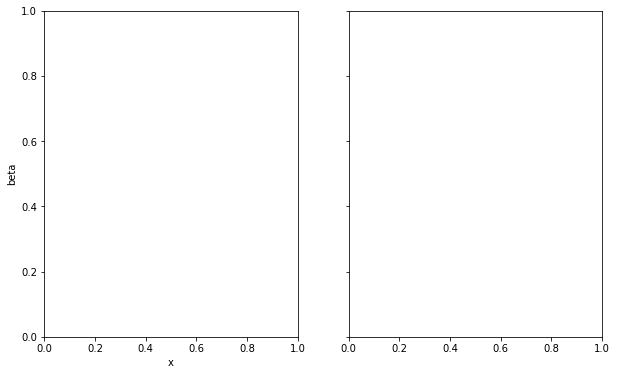

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2, sharey = True)

def init():
    ax1.set_xlabel('x')
    ax1.set_ylabel('beta')
    return (None,)

def animate(ep):
    sf = ep*100
    ef = (ep+1)*100
    #Plot 'true' beta^RD#Plot beta^BP as a function of x
    ax1.clear()
    ax2.clear()
    ax1.plot(xs, beta_bp[0,:], '.')
    ax2.plot(xs, beta_bp[1,:], '.')
    ax1.plot(xs[sf:ef], beta_rd[0,sf:ef], '.')
    ax2.plot(xs[sf:ef], beta_rd[1,sf:ef], '.')
    ax1.set_title("Time: %d"%sf)
    ax1.set_ylim([-3000, 3000])
    return (None,)        

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=500, blit=False)

In [10]:
rc('animation', html='html5')
matplotlib.rcParams['animation.writer'] = 'avconv'
HTML(anim.to_html5_video())

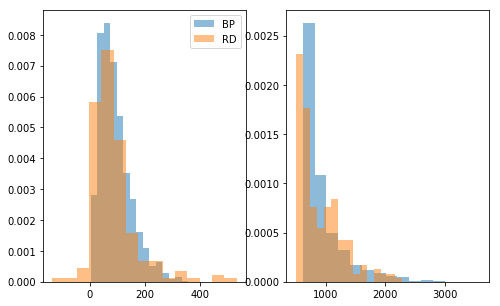

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,5));
ax1.hist(beta_bp[0,:], 15, normed=1, alpha=0.5);
ax1.hist(beta_rd[0,-200:], 15, normed=1, alpha=0.5);
ax1.legend(['BP', 'RD']);
ax2.hist(beta_bp[1,:], 15, normed=1, alpha=0.5);
ax2.hist(beta_rd[1,-200:], 15, normed=1, alpha=0.5);


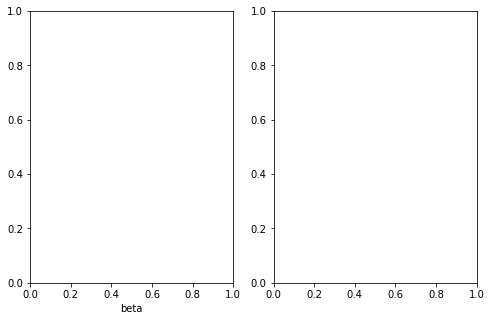

In [12]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,5));

def init():
    ax1.set_xlabel('beta')
    return (None,)

def animate(ep, nF):
    sf = ep*100
    ef = (ep+1)*100
    #Plot 'true' beta^RD
    #Plot beta^BP as a function of x
    ax1.clear()
    ax2.clear()
    ax1.hist(beta_bp[0,:], 15, normed=1, alpha=0.5, range=(-0, 3000));
    ax1.hist(beta_rd[0,sf:ef], 15, normed=1, alpha=0.5, range=(-0, 3000));
    ax1.legend(['BP', 'RD']);
    ax2.hist(beta_bp[1,:], 15, normed=1, alpha=0.5, range=(-0, 3000));
    ax2.hist(beta_rd[1,sf:ef], 15, normed=1, alpha=0.5, range=(-0, 3000));
    ax1.set_ylim([0, .02])
    ax2.set_ylim([0, .005])
    ax1.set_title("time: %d"%sf)
    return (None,)        

nF = 50
anim = animation.FuncAnimation(fig, lambda ep: animate(ep, nF), init_func=init,
                               frames=20, interval=500, blit=False)

In [13]:
rc('animation', html='html5')
matplotlib.rcParams['animation.writer'] = 'avconv'
HTML(anim.to_html5_video())

Of course! The LSM without recurrence doesn't actually project anything into a higher dimensional space. It just projects it into a 1D subspace of the higher neuronal space.

I need to make the LSM have stronger recurrence and try again.

This still only works ok. Will check to see if it learns the mean values over all x, then return to the issue of getting it right for beta as a function of x.

## Learning $\beta^{RD}$ for a range of $W$, and a range of $x$



In [14]:
#Simulate 1000 times, for a fixed W1 and W2.
n = 2               # Number of neurons
q = 100             # Number of LSM neurons
x = 2               # Constant input
alpha1 = 1000       # Cost function params
alpha2 = 1000      # Cost function params
tau_s = 0.060       # Time scale for output filter
mu = 1              # Threshold
p = 0.05            # Window size
t = 1               # Time for each epoch
N = 200             # Number of epochs
eta = .5            # Learning rate
sigma = 1           # Spread of input x distribution
x_mu = 3

Wn = 20
wmin = 1
wmax = 16

wvals = np.linspace(wmin, wmax, Wn)
costs = np.zeros((Wn, Wn))

# Filename for results
#fn_out = './sweeps/learningbeta_fixedx_sweepw.npz'

params = ParamsLSM(q = q, p = 1, t = t)
lsm = LSM(params)
params_lif = ParamsLIF(c = 0.75)
lif = LIF(params_lif, t = t)

t_filter = np.linspace(0, 0.45, 450)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

beta_rd = np.zeros((Wn, Wn, n, N))
beta_bp = np.zeros((Wn, Wn, n, N))
xs = np.zeros((Wn, Wn, N))

STstim = np.zeros((Wn, Wn, n, N))
STA = np.zeros((Wn, Wn, n))

for i,w0 in enumerate(wvals):
    print("w0 = %d"%w0)
    for j,w1 in enumerate(wvals):
        #init weights
        lif.W = np.array([w0, w1])
        V = np.ones((n,q))
        for idx in range(N):
            #Choose x at random
            x = sigma*rand.randn() + 2
            #x = 2
            xs[i,j,idx] = x
            #Simulate LSM
            s_lsm = lsm.simulate(x)
            #Simulate LIF
            lif.x = x
            (v, h, _, _) = lif.simulate()
            STstim[i,j,:,idx] = np.sum(h,1)
            s1 = np.convolve(h[0,:], exp_filter)[0:h.shape[1]]
            s2 = np.convolve(h[1,:], exp_filter)[0:h.shape[1]]            
            cost = (alpha1*s1 + alpha2*s2 - (x-1)**2)**2
            #Save the mean cost
            costs[i,j] += np.mean(cost)/N
            dV = np.zeros(V.shape)
            bt = [False, False]
            for t in range(v.shape[1]):
                for k in range(n):
                    if (v[k,t] > mu - p) & (v[k,t] < mu):
                        if bt[k] == False:
                            dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])+cost[t])*s_lsm[:,t]
                            bt[k] = True
                    elif (v[k,t] < mu + p) & (v[k,t] >= mu):
                        #Only do the update when firing...
                        if bt[k] == True:
                            dV[k,:] += (np.dot(V[k,:], s_lsm[:,t])-cost[t])*s_lsm[:,t]
                            V[k,:] = V[k,:] - eta*dV[k,:]
                            dV[k,:] = np.zeros((1,q))
                            bt[k] = False
            #s_lsm = lsm.simulate(x)
            beta_rd[i,j,:,idx] = np.mean(np.dot(V, s_lsm[:,-200:]),1)
            beta_bp[i,j,0,idx] = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2[-200:])*ds - 2*alpha1*((x-1)**2)*ds
            beta_bp[i,j,1,idx] = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1[-200:])*ds - 2*alpha2*((x-1)**2)*ds
        STA[i,j,0] = np.dot(STstim[i,j,0,:], xs[i,j,:])/np.sum(STstim[i,j,0,:])
        STA[i,j,1] = np.dot(STstim[i,j,1,:], xs[i,j,:])/np.sum(STstim[i,j,1,:])

w0 = -8
w0 = -7


/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in double_scalars


w0 = -6
w0 = -5
w0 = -4
w0 = -3
w0 = -2
w0 = -2
w0 = -1
w0 = 0


/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in double_scalars


w0 = 0
w0 = 1
w0 = 2
w0 = 2
w0 = 3
w0 = 4
w0 = 5
w0 = 6
w0 = 7
w0 = 8


In [15]:
np.sum(h,1)

array([ 23.,  23.])

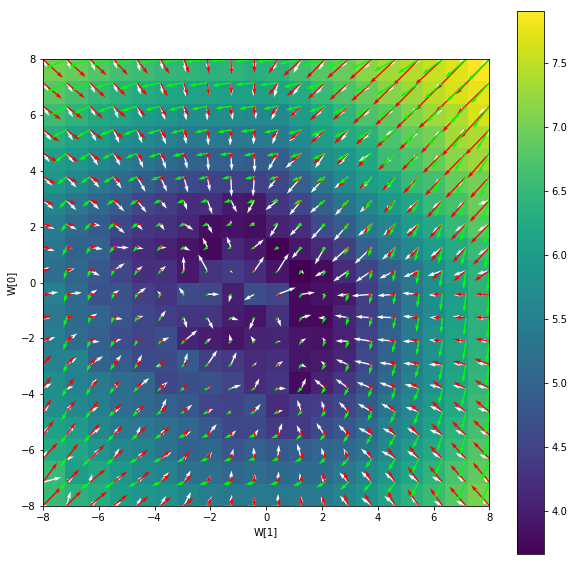

In [22]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
a=ax.imshow(np.log(costs), origin='lower', extent=[wmin, wmax, wmin, wmax])
plt.colorbar(a)
ax.set_ylabel('W[0]')
ax.set_xlabel('W[1]')

grad = np.gradient(np.log(costs))
X, Y = np.meshgrid(np.linspace(wmin,wmax,Wn), np.linspace(wmin,wmax,Wn))
ax.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))

#ax.quiver(X, Y, -np.multiply(np.mean(beta_rd[:,:,1,:], 2), STA[:,:,1]), -np.multiply(np.mean(beta_rd[:,:,0,:], 2), STA[:,:,0]), color=(1,0,0))
#ax.quiver(X, Y, -np.multiply(np.mean(beta_bp[:,:,1,:], 2), STA[:,:,1]), -np.multiply(np.mean(beta_bp[:,:,0,:], 2), STA[:,:,0]), color=(0,1,0))

#ax.quiver(X, Y, -np.mean(beta_rd[:,:,1,:], 2), -np.mean(beta_rd[:,:,0,:], 2), color=(1,0,0))
ax.quiver(X, Y, -np.multiply(np.mean(beta_rd[:,:,1,:], 2), np.sign(X)), -np.multiply(np.mean(beta_rd[:,:,0,:], 2), np.sign(Y)), color=(1,0,0))
ax.quiver(X, Y, -np.mean(beta_bp[:,:,1,:], 2), -np.mean(beta_bp[:,:,0,:], 2), color=(0,1,0))
#beta_rd[i,j,:,idx] = np.mean(np.dot(V, s_lsm[:,-200:]),1)
#beta_bp[i,j,0,idx] = (alpha1**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s2[-200:])*ds - 2*alpha1*((x-1)**2)*ds
#beta_bp[i,j,1,idx] = (alpha2**2)*(ds**2) + 2*alpha1*alpha2*np.mean(s1[-200:])*ds - 2*alpha2*((x-1)**2)*ds

Now we need a correction for the 'spike triggered stimulus', which probably explains the differences here.

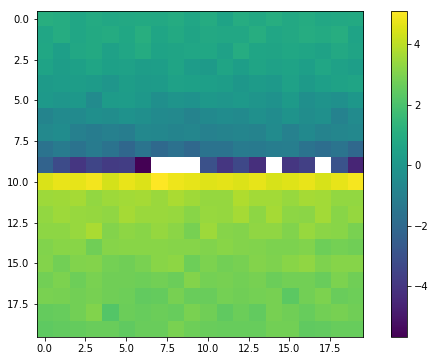

In [17]:
a=plt.imshow(STA[:,:,0])
plt.colorbar(a)

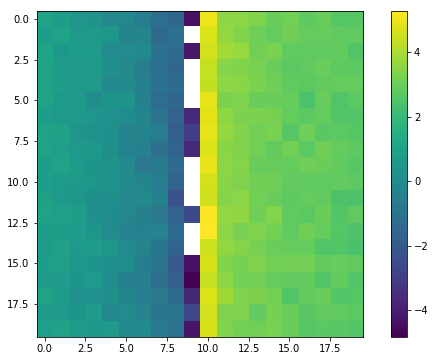

In [18]:
a=plt.imshow(STA[:,:,1])
plt.colorbar(a)